In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import (
    KFold,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import shap

warnings.filterwarnings("ignore", category=FutureWarning)
plt.style.use("fast")

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
full_train = train_df.drop(["id"], axis=1)
test_df = test_df.drop(["id"], axis=1)
full_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 19 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Name                                   140700 non-null  object 
 1   Gender                                 140700 non-null  object 
 2   Age                                    140700 non-null  float64
 3   City                                   140700 non-null  object 
 4   Working Professional or Student        140700 non-null  object 
 5   Profession                             104070 non-null  object 
 6   Academic Pressure                      27897 non-null   float64
 7   Work Pressure                          112782 non-null  float64
 8   CGPA                                   27898 non-null   float64
 9   Study Satisfaction                     27897 non-null   float64
 10  Job Satisfaction                       112790 non-null  

In [3]:
full_train.describe().round(2).style.format(precision=2).background_gradient(
    cmap="Blues"
)

,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,140700.00,27897.00,112782.00,27898.00,27897.00,112790.00,140700.00,140696.00,140700.00
mean,40.39,3.14,3.00,7.66,2.94,2.97,6.25,2.99,0.18
std,12.38,1.38,1.41,1.46,1.36,1.42,3.85,1.41,0.39
min,18.00,1.00,1.00,5.03,1.00,1.00,0.00,1.00,0.00
25%,29.00,2.00,2.00,6.29,2.00,2.00,3.00,2.00,0.00
50%,42.00,3.00,3.00,7.77,3.00,3.00,6.00,3.00,0.00
75%,51.00,4.00,4.00,8.92,4.00,4.00,10.00,4.00,0.00
max,60.00,5.00,5.00,10.00,5.00,5.00,12.00,5.00,1.00


In [4]:
def new_feats(df):
    df = (
        df.assign(satisfaction_by_work=df["Work Pressure"] / df["Job Satisfaction"])
        .assign(
            satisfaction_by_study=df["Academic Pressure"] / df["Study Satisfaction"]
        )
        .assign(age_work_satisfaction=df["Age"] / df["Job Satisfaction"])
        .assign(cgpa_study=df["CGPA"] / df["Academic Pressure"])
    )
    return df

In [5]:
full_train = new_feats(full_train).copy()
test_df = new_feats(test_df).copy()
print("*************************************")
print("----------full_train Shape------------")
print(full_train.shape)
print("*************************************")
print("----------test_df Shape------------")
print(test_df.shape)
print("*************************************")

*************************************
----------full_train Shape------------
(140700, 23)
*************************************
----------test_df Shape------------
(93800, 22)
*************************************


In [6]:
num_feats = full_train.select_dtypes(include="float64").columns
obj_feats = full_train.select_dtypes(include="object").columns
target = full_train.select_dtypes(include="int64").columns
print("*************************************")
print("----------Numerical Featuers---------")
print(num_feats)
print("*************************************")
print("----------Object Featuers------------")
print(obj_feats)
print("*************************************")
print("----------Target Variable------------")
print(target)
print("*************************************")

*************************************
----------Numerical Featuers---------
Index(['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours',
       'Financial Stress', 'satisfaction_by_work', 'satisfaction_by_study',
       'age_work_satisfaction', 'cgpa_study'],
      dtype='object')
*************************************
----------Object Featuers------------
Index(['Name', 'Gender', 'City', 'Working Professional or Student',
       'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?',
       'Family History of Mental Illness'],
      dtype='object')
*************************************
----------Target Variable------------
Index(['Depression'], dtype='object')
*************************************


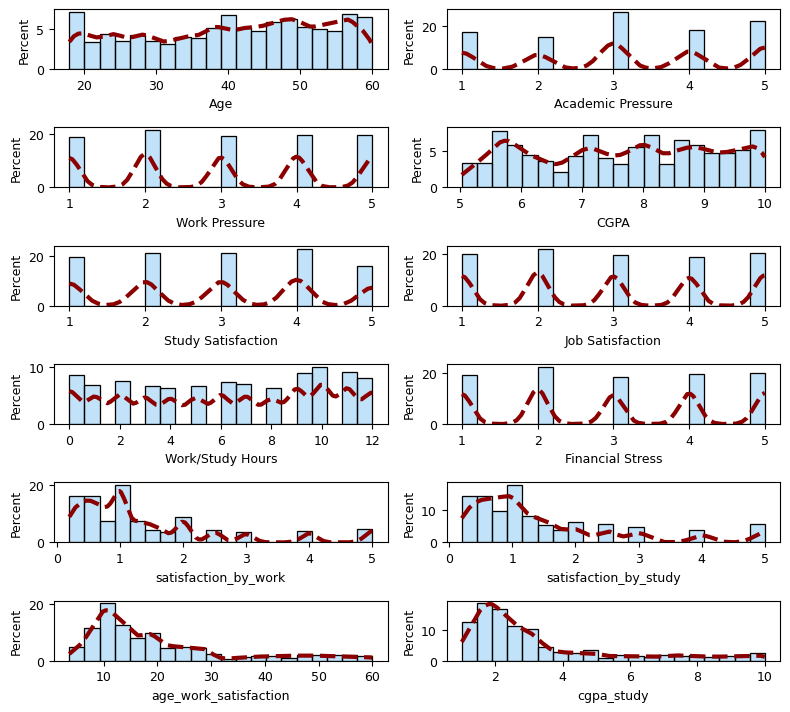

In [7]:
fig = plt.figure(figsize=(8, 8))

for i, feature in enumerate(num_feats):
    ax = fig.add_subplot(7, 2, i + 1)
    sns.histplot(
        full_train[feature],
        stat="percent",
        kde=True,
        bins=20,
        alpha=0.4,
        color="#66b7ee",
        line_kws={"lw": 3, "linestyle": "dashed"},
    ).lines[0].set_color("darkred")
    plt.tick_params(axis="both", labelsize=9)
    plt.ylabel("Percent", fontsize=9)
    plt.xlabel(feature, fontsize=9)


fig.tight_layout()
plt.show()

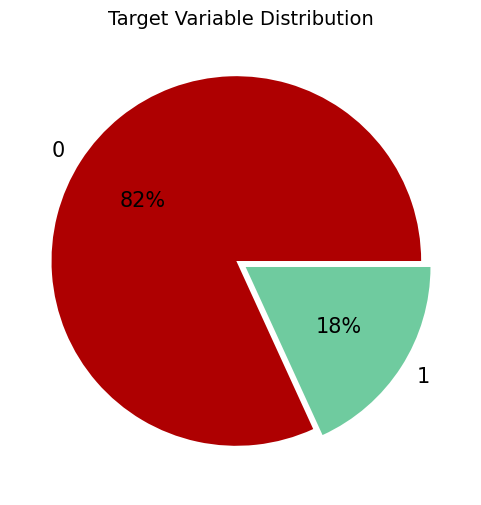

In [8]:
target_colors = [
    "#ae0001",
    "#6fcb9f",
]
plt.figure(figsize=(6, 6))
plt.pie(
    full_train["Depression"].value_counts(),
    labels=full_train["Depression"].value_counts().index,
    textprops={"fontsize": 15, "color": "black"},
    colors=target_colors,
    autopct="%.0f%%",
    explode=[0.03, 0.03],
)
plt.title("Target Variable Distribution", fontsize=14)
plt.show()

In [9]:
deg = full_train["Degree"].value_counts()[0:27].reset_index()["Degree"].to_list()
full_train["Degree"] = np.where(full_train["Degree"].isin(deg), full_train["Degree"], "Other")
test_df["Degree"] = np.where(test_df["Degree"].isin(deg), test_df["Degree"], "Other")
print("****************************")
print("----------full_train--------")
print(full_train["Degree"].value_counts())
print("****************************")
print("----------test_df-----------")
print(test_df["Degree"].value_counts())
print("****************************")

****************************
----------full_train--------
Degree
Class 12    14729
B.Ed        11691
B.Arch       8742
B.Com        8113
B.Pharm      5856
BCA          5739
M.Ed         5668
MCA          5234
BBA          5030
BSc          5027
MSc          4879
LLM          4647
M.Pharm      4537
M.Tech       4475
B.Tech       4425
LLB          4348
BHM          4305
MBA          3818
BA           3750
ME           3632
MD           3383
MHM          3286
BE           3104
PhD          3103
M.Com        3094
MBBS         3082
MA           2887
Other         116
Name: count, dtype: int64
****************************
----------test_df-----------
Degree
Class 12    9812
B.Ed        7762
B.Arch      6037
B.Com       5439
B.Pharm     3987
BCA         3869
M.Ed        3707
MCA         3438
BBA         3387
BSc         3314
LLM         3133
MSc         3096
M.Tech      3017
M.Pharm     2995
LLB         2938
B.Tech      2885
BHM         2776
BA          2490
MBA         2470
ME          2391


In [10]:
dh = full_train["Dietary Habits"].value_counts()[0:3].reset_index()["Dietary Habits"].to_list()
full_train["Dietary Habits"] = np.where(full_train["Dietary Habits"].isin(dh), full_train["Dietary Habits"], "Moderate")
test_df["Dietary Habits"] = np.where(test_df["Dietary Habits"].isin(dh), test_df["Dietary Habits"], "Moderate")
print("****************************")
print("----------full_train---------")
print(full_train["Dietary Habits"].value_counts())
print("****************************")
print("----------test_df------------")
print(test_df["Dietary Habits"].value_counts())
print("****************************")

****************************
----------full_train---------
Dietary Habits
Moderate     49732
Unhealthy    46227
Healthy      44741
Name: count, dtype: int64
****************************
----------test_df------------
Dietary Habits
Moderate     33048
Unhealthy    30786
Healthy      29966
Name: count, dtype: int64
****************************


In [11]:
sleep_d =full_train["Sleep Duration"].value_counts()[0:4].reset_index()["Sleep Duration"].to_list()
full_train["Sleep Duration"] = np.where(full_train["Sleep Duration"].isin(sleep_d), full_train["Sleep Duration"], "1-8")
test_df["Sleep Duration"] = np.where(test_df["Sleep Duration"].isin(sleep_d), test_df["Sleep Duration"], "1-8")
print("****************************")
print("----------full_train---------")
print(full_train["Sleep Duration"].value_counts())
print("****************************")
print("----------test_df------------")
print(test_df["Sleep Duration"].value_counts())
print("****************************")

****************************
----------full_train---------
Sleep Duration
Less than 5 hours    38784
7-8 hours            36969
More than 8 hours    32726
5-6 hours            32142
1-8                     79
Name: count, dtype: int64
****************************
----------test_df------------
Sleep Duration
Less than 5 hours    25661
7-8 hours            24491
More than 8 hours    22190
5-6 hours            21404
1-8                     54
Name: count, dtype: int64
****************************


In [12]:
pro = full_train["Profession"].value_counts()[1:35].reset_index()["Profession"].to_list()
full_train["Profession"] = np.where(full_train["Profession"].isin(pro), full_train["Profession"], "Other")
test_df["Profession"] = np.where(test_df["Profession"].isin(pro), test_df["Profession"], "Other")
print("****************************")
print("----------full_train---------")
print(full_train["Profession"].value_counts())
print("****************************")
print("----------test_df------------")
print(test_df["Profession"].value_counts())
print("****************************")

****************************
----------full_train---------
Profession
Other                     61586
Content Writer             7814
Architect                  4370
Consultant                 4229
HR Manager                 4022
Pharmacist                 3893
Doctor                     3255
Business Analyst           3161
Entrepreneur               2968
Chemist                    2967
Chef                       2862
Educational Consultant     2852
Data Scientist             2390
Researcher                 2328
Lawyer                     2212
Customer Support           2055
Marketing Manager          1976
Pilot                      1913
Travel Consultant          1860
Plumber                    1748
Sales Executive            1739
Manager                    1737
Judge                      1712
Electrician                1582
Financial Analyst          1574
Software Engineer          1510
Civil Engineer             1470
UX/UI Designer             1452
Digital Marketer           1372
Ac

In [ ]:
df_sample_n = (
    full_train.groupby("Depression")
    .sample(frac=0.01, random_state=42)
    .reset_index(drop=True)
)
pair_cols = num_feats.append(target)
sns.pairplot(
    df_sample_n[pair_cols],
    hue="Depression",
    kind="scatter",
    diag_kind="kde",
    palette=target_colors,
    height=2,
    aspect=1.5,
    plot_kws=dict(s=10),
)

plt.show()

In [ ]:
plt.style.use("default")
corr_mat = full_train[num_feats].corr()
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
cmap = sns.diverging_palette(230, 30, as_cmap=True)
f, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(
    corr_mat,
    mask=mask,
    cbar=True,
    cmap=cmap,
    center=0,
    square=False,
    annot=False,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation Matrix\n")
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

# CatBoost

In [13]:
full_train = full_train.fillna("0")
test_df = test_df.fillna("0")
full_train[num_feats] = full_train[num_feats].astype("float64")
full_train[obj_feats] = full_train[obj_feats].astype("string")
full_train[target] = full_train[target].astype("int64")
test_df[num_feats] = test_df[num_feats].astype("float64")
test_df[obj_feats] = test_df[obj_feats].astype("string")

In [14]:
full_train.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,...,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,satisfaction_by_work,satisfaction_by_study,age_work_satisfaction,cgpa_study
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,0.0,5.0,0.00,0.0,...,BHM,No,1.0,2.0,No,0,2.500000,0.0,24.500000,0.000
1,Vivan,Male,26.0,Varanasi,Working Professional,Other,0.0,4.0,0.00,0.0,...,LLB,Yes,7.0,3.0,No,1,1.333333,0.0,8.666667,0.000
2,Yuvraj,Male,33.0,Visakhapatnam,Student,Other,5.0,0.0,8.97,2.0,...,B.Pharm,Yes,3.0,1.0,No,1,0.000000,2.5,0.000000,1.794
3,Yuvraj,Male,22.0,Mumbai,Working Professional,Other,0.0,5.0,0.00,0.0,...,BBA,Yes,10.0,1.0,Yes,1,5.000000,0.0,22.000000,0.000
4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,0.0,1.0,0.00,0.0,...,BBA,Yes,9.0,4.0,Yes,0,1.000000,0.0,30.000000,0.000


In [15]:
y = full_train["Depression"]
X = full_train.drop(["Depression"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=4
)

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98490 entries, 96048 to 115397
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Name                                   98490 non-null  string 
 1   Gender                                 98490 non-null  string 
 2   Age                                    98490 non-null  float64
 3   City                                   98490 non-null  string 
 4   Working Professional or Student        98490 non-null  string 
 5   Profession                             98490 non-null  string 
 6   Academic Pressure                      98490 non-null  float64
 7   Work Pressure                          98490 non-null  float64
 8   CGPA                                   98490 non-null  float64
 9   Study Satisfaction                     98490 non-null  float64
 10  Job Satisfaction                       98490 non-null  float64
 11  Sl

In [ ]:
cat_params = {'iterations': 545,
 'learning_rate': 0.09928248945425253,
 'colsample_bylevel': 0.8829334721878778,
 'subsample': 0.5547932441628254,
 'min_data_in_leaf': 2,
 'depth': 6,
 'l2_leaf_reg': 18.745159259296127,
 'random_strength': 0.6462407394010031}

In [19]:
shap_df = (
    full_train
    .groupby('Depression')
    [full_train.columns.tolist()]
    .apply(lambda x: x.sample(frac=0.02), include_groups=True)
    .reset_index(drop=True)
    .copy()
    )

In [21]:
shap_df

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,...,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,satisfaction_by_work,satisfaction_by_study,age_work_satisfaction,cgpa_study
0,Rohan,Male,57.0,Lucknow,Working Professional,Judge,0.0,2.0,0.00,0.0,...,LLM,Yes,7.0,2.0,Yes,0,0.666667,0.0,19.0,0.000000
1,Sanket,Male,37.0,Bhopal,Working Professional,Other,0.0,3.0,0.00,0.0,...,MBBS,No,0.0,5.0,No,0,3.000000,0.0,37.0,0.000000
2,Rhea,Female,30.0,Meerut,Working Professional,Travel Consultant,0.0,1.0,0.00,0.0,...,MHM,No,7.0,1.0,No,0,0.200000,0.0,6.0,0.000000
3,Manan,Male,32.0,Visakhapatnam,Student,Other,2.0,0.0,7.68,5.0,...,B.Ed,No,10.0,3.0,Yes,0,0.000000,0.4,0.0,3.840000
4,Ritvik,Male,29.0,Meerut,Student,Other,1.0,0.0,9.96,2.0,...,B.Tech,No,0.0,3.0,No,0,0.000000,0.5,0.0,9.960000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2809,Gaurav,Male,18.0,Kalyan,Student,Other,4.0,0.0,7.77,4.0,...,Class 12,No,12.0,4.0,Yes,1,0.000000,1.0,0.0,1.942500
2810,Ayaan,Male,21.0,Ahmedabad,Working Professional,Educational Consultant,0.0,5.0,0.00,0.0,...,B.Ed,Yes,0.0,5.0,Yes,1,5.000000,0.0,21.0,0.000000
2811,Shiv,Male,23.0,Srinagar,Student,Other,3.0,0.0,9.79,1.0,...,BSc,Yes,10.0,4.0,Yes,1,0.000000,3.0,0.0,3.263333
2812,Jiya,Female,25.0,Surat,Student,Other,5.0,0.0,7.47,1.0,...,M.Com,Yes,10.0,5.0,Yes,1,0.000000,5.0,0.0,1.494000


In [20]:
y_shap = shap_df["Depression"]
X_shap = shap_df.drop(["Depression"], axis=1)
X_train_shap, X_test_shap, y_train_shap, y_test_shap = train_test_split(
    X_shap, y_shap, test_size=0.2, random_state=1
)
X_display, y_display = X_train_shap, y_train_shap

In [22]:
X[obj_feats].columns.values

array(['Name', 'Gender', 'City', 'Working Professional or Student',
       'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?',
       'Family History of Mental Illness'], dtype=object)

In [23]:
cat_interp = CatBoostClassifier(**cat_params, verbose=False, cat_features=X[obj_feats].columns.values, early_stopping_rounds=200)
cat_interp.fit(X_train_shap, y_train_shap)
shap.initjs()
explainer = shap.TreeExplainer(cat_interp)
shap_values = explainer(X_train_shap)

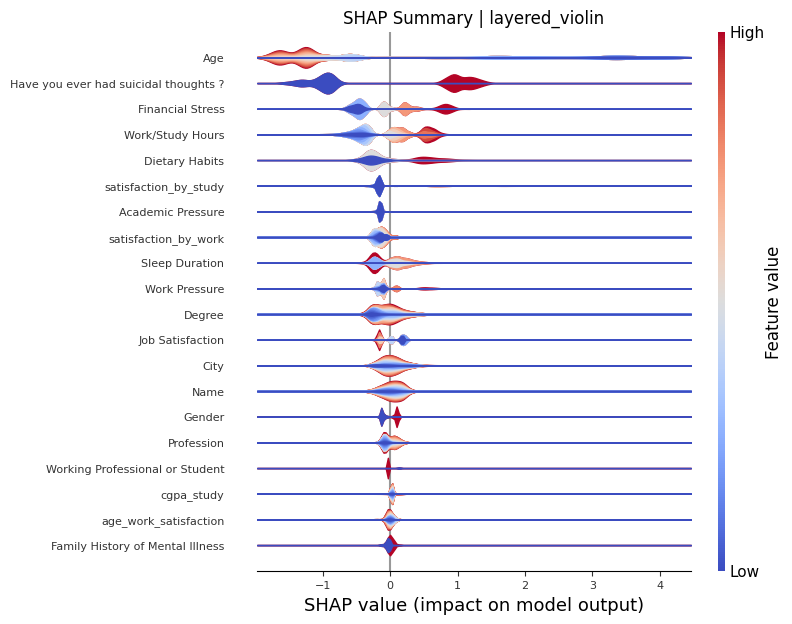

In [24]:
shap.plots.violin(shap_values, plot_type="layered_violin", show = False)
fig, ax = plt.gcf(), plt.gca()
fig.set_figheight(7)
fig.set_figwidth(7)
ax.tick_params(labelsize=8)
ax.set_title("SHAP Summary | layered_violin", fontsize=12)
plt.show()

In [ ]:
cat_cv_last = StratifiedKFold(20, shuffle=True, random_state=42)
cat_cv_splits = cat_cv_last.split(X, y)
acc_scores = []
last_test_df_preds = []
X_test_df_pool = Pool(test_df, cat_features=X[obj_feats].columns.values)

In [ ]:
for i, (full_train_idx, valid_idx) in enumerate(cat_cv_splits):
    model_fold = CatBoostClassifier(**cat_params)
    X_train_fold, X_valid_fold = X.loc[full_train_idx], X.loc[valid_idx]
    y_train_fold, y_valid_fold = y.loc[full_train_idx], y.loc[valid_idx]
    X_train_pool = Pool(X_train_fold, y_train_fold, cat_features=X[obj_feats].columns.values)
    X_valid_pool = Pool(X_valid_fold, y_valid_fold, cat_features=X[obj_feats].columns.values)
    model_fold.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=False, early_stopping_rounds=100)
    valid_pred = model_fold.predict(X_valid_pool)
    score = accuracy_score(y_valid_fold, valid_pred)
    acc_scores.append(score)
    test_df_pred = model_fold.predict_proba(X_test_df_pool)[:, 1]
    last_test_df_preds.append(test_df_pred)
    print(f'Fold {i + 1} Accuracy Score: {score}')

In [ ]:
sample_submission = pd.read_csv("data/sample_submission.csv")
sample_submission.Depression = np.round(np.mean(last_test_df_preds, axis=0))
sample_submission

In [ ]:
sample_submission